In [1]:
import os
import gc
import glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import utils

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm
import pickle

np.random.seed(7)
torch.manual_seed(7)

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
class CustomDataset(Dataset):
    def __init__(self, img_paths_and_labels_list, class_map,transform = None):
        self.data = img_paths_and_labels_list
        self.class_map = class_map
        self.transform = transform
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = np.load(img_path, allow_pickle = True)
        if class_name == 'axion':
            img = img[0]
        
#         img = np.expand_dims(img, axis = 0)
        
        if self.transform:
            aug = self.transform(image=img)
            img = aug['image']
        
        img = img.to(torch.float)
        class_id = self.class_map[class_name]
        class_id = torch.tensor(class_id)

        return img, class_id

In [3]:
 transforms = A.Compose(
            [
                A.CenterCrop(height = 100, width = 100, p=1.0),
                ToTensorV2()
            ]
        )
    
class_map = {'axion': 0, 'no_sub': 1, 'cdm': 2}
classes = []
for key in class_map:
    classes.append(key)
classes

['axion', 'no_sub', 'cdm']

In [4]:
#Using a batch size of 128
BS = 64

In [5]:
with open('../input/gsoc-model1-centercrop/test_set_image_paths_list.pickle', 'rb') as f:
    test_set_image_paths_list = pickle.load(f)

In [6]:
test_set = CustomDataset(test_set_image_paths_list, class_map, transform = transforms)
print(len(test_set))

8753


In [7]:
test_loader = DataLoader(test_set, batch_size = BS, shuffle = False)

In [8]:
single_batch = next(iter(test_loader))
single_batch[0].shape

torch.Size([64, 1, 100, 100])

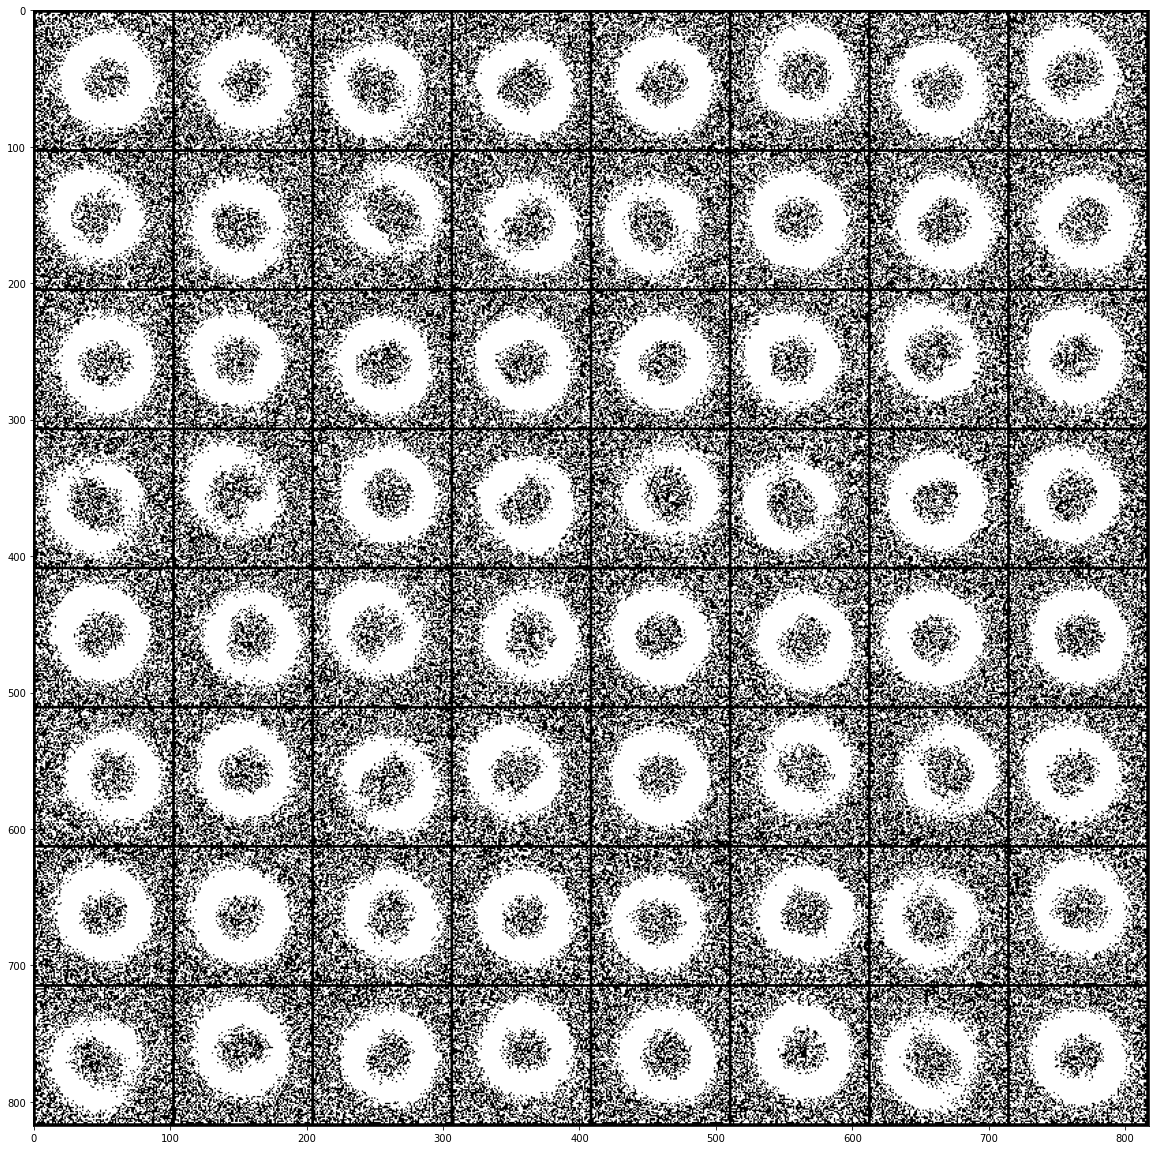

In [9]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=8)
plt.figure(figsize = (20,70))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [10]:
class pre_trained_model(nn.Module):
    
    def __init__(self, pretrained = True):
        super().__init__()
        self.model = timm.create_model('efficientnet_b2',pretrained = pretrained, in_chans = 1)
#         num_in_features = self.model.get_classifier().in_features
        
        for param in self.model.parameters():
            param.requires_grad = True            
        
        self.fc = nn.Sequential(
                                nn.Linear(1408 * 4 * 4, 1024),
                                nn.PReLU(),
                                nn.BatchNorm1d(1024),
                                nn.Dropout(p = 0.5),
                                
                                nn.Linear(1024, 512),
                                nn.BatchNorm1d(512),
                                nn.PReLU(),
                                nn.Dropout(p = 0.5),
        
                                nn.Linear(512, 128),
                                nn.PReLU(),
                                nn.BatchNorm1d(128),
                                nn.Dropout(p = 0.3),
                                
                                nn.Linear(128, 3)
                                )
        
    def forward(self, x):
        x = self.model.forward_features(x)
        x = x.view(-1, 1408 * 4 * 4)
        x = self.fc(x)
        return x

In [11]:
PATH = r'../input/gsoc-model1-centercrop/effnetB3_centercrop.pth'
model = pre_trained_model().to(device)

model = pre_trained_model().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(),lr=LR)

try:
    model.load_state_dict(torch.load(PATH))
except:
    map_location=torch.device('cpu')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


In [12]:
def calculate_accuracy(y_pred, y_truth):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_labels = torch.max(y_pred_softmax, dim = 1)
    
    correct_preds = (y_pred_labels == y_truth).float()
    acc = correct_preds.sum() / len(correct_preds)
    acc = torch.round(acc*100)
    
    return acc 

In [13]:
def test_epoch(model, dataloader,criterion):

    model.eval()
    test_loss = []
    test_accuracy = []
    
    y_pred_list = []
    y_pred_prob_list = []
    y_truth_list = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,labels) in loop:
            X = img_batch.to(device)
            y_truth = labels.to(device)
            y_truth_list.append(y_truth.detach().cpu().numpy())

            #forward prop
            y_pred = model(X)
            y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
            y_pred_prob_list.append(torch.softmax(y_pred, dim = 1).detach().cpu().numpy())
            _, y_pred_labels = torch.max(y_pred_softmax, dim = 1)
            y_pred_list.append(y_pred_labels.detach().cpu().numpy())

            #loss and accuracy calculation
            loss = criterion(y_pred, y_truth)
            accuracy = calculate_accuracy(y_pred, y_truth)


            #batch loss and accuracy
            # print(f'Partial train loss: {loss.data}')
            test_loss.append(loss.detach().cpu().numpy())
            test_accuracy.append(accuracy.detach().cpu().numpy())
            
    return y_pred_prob_list, y_pred_list, y_truth_list, np.mean(test_loss), np.mean(test_accuracy)

In [14]:
y_pred_prob_list, y_pred_list, y_truth_list, test_loss, test_accuracy = test_epoch(model, test_loader, criterion)

print(test_loss, test_accuracy)

  0%|          | 0/137 [00:00<?, ?it/s]

0.21778232 96.350365


In [15]:
def flatten_list(x):
    flattened_list = []
    for i in x:
        for j in i:
            flattened_list.append(j)
            
    return flattened_list

In [16]:
y_pred_list_flattened = flatten_list(y_pred_list)
y_truth_list_flattened = flatten_list(y_truth_list)
y_pred_prob_list_flattened = flatten_list(y_pred_prob_list)

In [17]:
np.array(y_pred_prob_list_flattened)

array([[7.4627826e-10, 1.0000000e+00, 1.7847404e-08],
       [3.3840804e-06, 9.9990416e-01, 9.2480856e-05],
       [9.9964714e-01, 4.0220016e-06, 3.4881925e-04],
       ...,
       [6.3724199e-09, 9.9999988e-01, 7.1983770e-08],
       [2.1820508e-06, 1.1829599e-06, 9.9999666e-01],
       [2.7031433e-06, 1.8170007e-06, 9.9999547e-01]], dtype=float32)

In [18]:
idx2class = {v: k for k, v in class_map.items()}
class_names = [i for i in class_map.keys()]
idx2class

{0: 'axion', 1: 'no_sub', 2: 'cdm'}

In [19]:
print(classification_report(y_truth_list_flattened, y_pred_list_flattened,target_names = class_names))

              precision    recall  f1-score   support

       axion       0.94      0.96      0.95      2890
      no_sub       0.99      1.00      0.99      2886
         cdm       0.96      0.94      0.95      2977

    accuracy                           0.96      8753
   macro avg       0.96      0.96      0.96      8753
weighted avg       0.96      0.96      0.96      8753



In [20]:
print(confusion_matrix(y_pred_list_flattened, y_truth_list_flattened))

[[2782    0  163]
 [   0 2877   30]
 [ 108    9 2784]]


<AxesSubplot:>

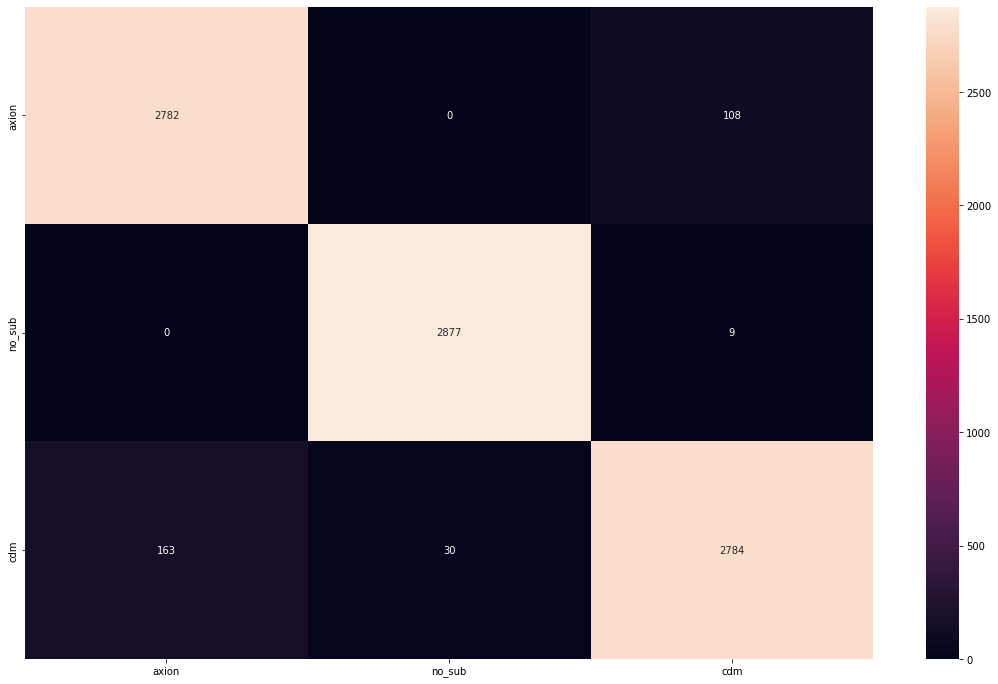

In [21]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_truth_list_flattened, y_pred_list_flattened)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(19,12))         
sns.heatmap(confusion_matrix_df, fmt = ".0f", annot=True, ax=ax)

In [22]:
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='macro', multi_class="ovr"))
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='macro', multi_class="ovo"))
print()
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='weighted', multi_class="ovr"))
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='weighted', multi_class="ovo"))

0.9949833241278032
0.9950134895394864

0.9949455260489157
0.994988827711486


In [23]:
fpr = {}
tpr = {}
roc_auc = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(np.array(y_truth_list_flattened), np.array(y_pred_prob_list_flattened)[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

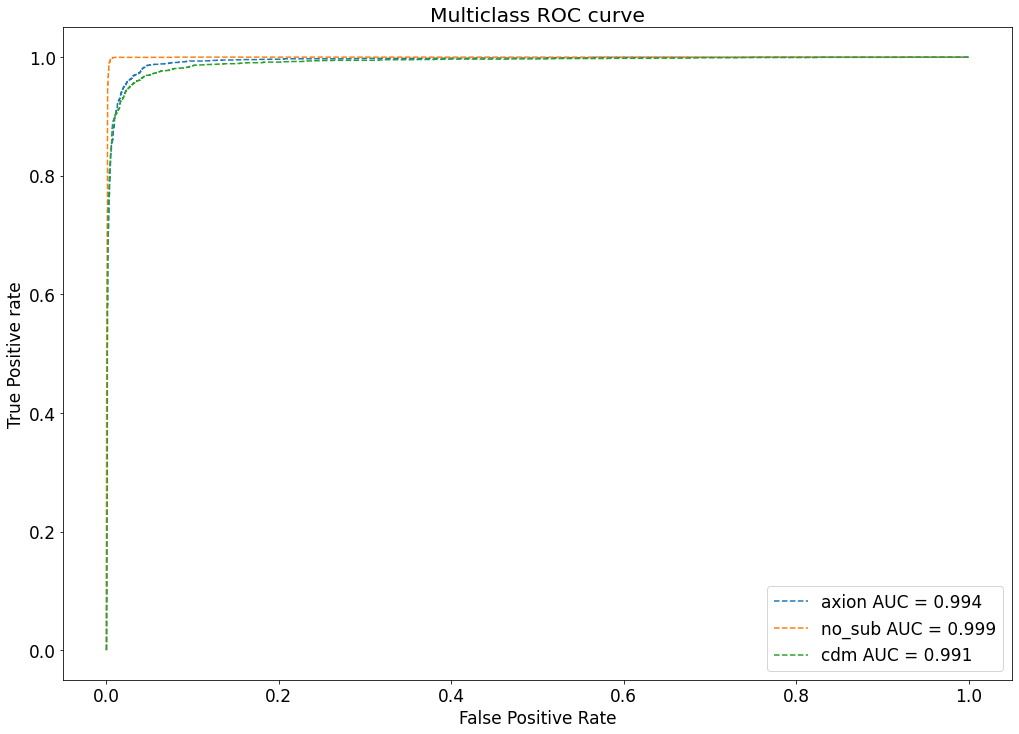

In [24]:
plt.figure(figsize=(17,12))
plt.rcParams['font.size'] = '17'
for i in range(0,n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'{idx2class[i]} AUC = {roc_auc[i]:.3f}')

    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    
plt.savefig('CNN_Multiclass ROC full.png',dpi=352);   